In [1]:
import openmc
import numpy as np
from matplotlib import pyplot as plt

# OpenMC Particle Tracks (and Lost Particles)

Tally information produced by Monte Carlo codes is the result of contributions from numerous particles, but it's often insightful to examine the history of these particles individually. This can be helpful in the following tasks:

  - debugging
  - source verification
  - tally estimator prototyping
  - problem visualization

In this module we will explore OpenMC's ability to generate, examine and visualize these files.


# Generating Particle Tracks



Two settings govern which tracks will be written from the OpenMC simulation:

  - `openmc.Settings.max_tracks`: The maximum number of tracks OpenMC will write (per MPI process).
  - `openmc.Settings.tracks`: A list of 3-tuples where each tuple entry in the list represents the batch number, generation number, and particle number to write.

Any of the following will execute OpenMC in a mode that produces a particle track file:

  - From a Python interpreter: 
    - `model.run(tracks=True)`
    - `openmc.run(tracks=True)`
  - From a terminal:
    - `$ openmc -t`

Once the simulation is complete, a `tracks.h5` will be produced. A specification for this file can be found [here](https://docs.openmc.org/en/stable/io_formats/track.html#track-file-format). We'll again be using the PWR pincell model to explore this feature.

In [2]:
model = openmc.examples.pwr_pin_cell()
model.settings.max_tracks = 20
model.settings.photon_transport = True
model.run(tracks=True)

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

PosixPath('/filespace/s/shriwise/ne506/content/openmc/statepoint.10.h5')

# Examining Particle Track Files

OpenMC provides classes to facilitate examination and usage of the `tracks.h5` file:

In [3]:
tracks = openmc.Tracks('tracks.h5')
tracks

[<Track (1, 1, 1): 561 particles>,
 <Track (1, 1, 10): 123 particles>,
 <Track (1, 1, 11): 404 particles>,
 <Track (1, 1, 19): 1 particles>,
 <Track (1, 1, 20): 817 particles>,
 <Track (1, 1, 21): 500 particles>,
 <Track (1, 1, 28): 625 particles>,
 <Track (1, 1, 37): 677 particles>,
 <Track (1, 1, 38): 22 particles>,
 <Track (1, 1, 39): 21 particles>,
 <Track (1, 1, 45): 536 particles>,
 <Track (1, 1, 53): 788 particles>,
 <Track (1, 1, 61): 366 particles>,
 <Track (1, 1, 62): 132 particles>,
 <Track (1, 1, 69): 1 particles>,
 <Track (1, 1, 70): 69 particles>,
 <Track (1, 1, 77): 578 particles>,
 <Track (1, 1, 85): 600 particles>,
 <Track (1, 1, 93): 97 particles>,
 <Track (1, 1, 94): 653 particles>]

Like several other objects provided by the `openmc` module, this object is an extension of the Python built-in `list` type and supports the same set of operations, including indexing.

Each `Track` in the `Tracks` object stores the information of the primary particle (the particle sourced at the beginning of the history) as well as any secondary particles generated during transport.



In [4]:
track0 = tracks[0]
track0

<Track (1, 1, 1): 561 particles>

The information of each particle in a `Track` object can be accessed using the `particle_tracks` attribute.

In [5]:
photon = track0.particle_tracks[1]
photon

<ParticleTrack: photon, 11 states>

In [6]:
track0.particle_tracks[-1].states

array([((0.15109603, -0.30034986, -0.47647205), (0.17564472, 0.92050389, 0.34902939), 480311.2135109, 4.04735791e-10, 1., 1, 0, 1),
       ((0.15109603, -0.30034986, -0.47647205), (0.17564472, 0.92050389, 0.34902939),      0.       , 4.04735791e-10, 0., 1, 0, 1)],
      dtype={'names': ['r', 'u', 'E', 'time', 'wgt', 'cell_id', 'cell_instance', 'material_id'], 'formats': [[('x', '<f8'), ('y', '<f8'), ('z', '<f8')], [('x', '<f8'), ('y', '<f8'), ('z', '<f8')], '<f8', '<f8', '<f8', '<i4', '<i4', '<i4'], 'offsets': [0, 24, 48, 56, 64, 72, 76, 80], 'itemsize': 88})

The `ParticleTrack` class contains the state for each particle in the `Track`. This is what we can use to find information about the primary and secondary particle histories':

The full list of fields is as follows:

- **r**: Position (each direction in [cm])
- **u**: Direction
- **E**: Energy in [eV]
- **time**: Time in [s]
- **wgt**: Weight
- **cell_id**: Cell ID
- **cell_instance**: Cell instance
- **material_id**: Material ID

Because some particle tracks can contain a large number of secondary particles, a `Track.filter` provides a method for down-selecting secondary particles quickly.

In [7]:
fuel_cell = model.geometry.get_cells_by_name('Fuel')[0]
track0.filter(particle='photon', state_filter=lambda s: s['cell_id'] == fuel_cell.id)

<Track (1, 1, 1): 50 particles>

# Visualizing Particle Tracks

Particle tracks can also be used in visualizations using the `Track.plot` method.




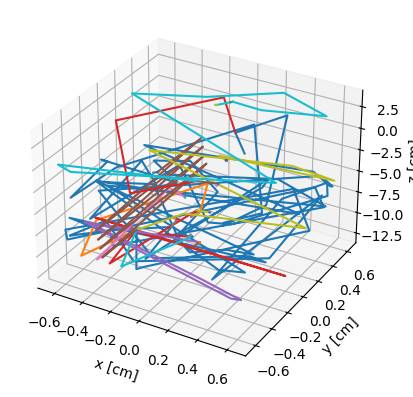

In [8]:
track0.plot()
plt.show()

Finally, particle tracks can be written to a VTK file for visualization in tools like Paraview or VisIt.

With a a little extra work, the state information can be used the display track information on top of the geometry as well, of course.

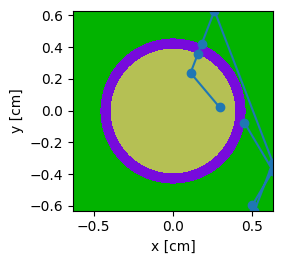

In [9]:
particle_track = track0.particle_tracks[0]
xs = np.array([state['r'][0] for state in particle_track.states[:10]])
ys = np.array([state['r'][1] for state in particle_track.states[:10]])

ax = model.geometry.plot()
ax.plot(xs, ys, 'o-')
plt.show()

Let's make some modifications before we start to enhance our understanding of OpenMC's track capabilities later on:

  - name all of the `openmc.Cell`'s in the model with a predictable name
  - set colors for cell appearance in the plots

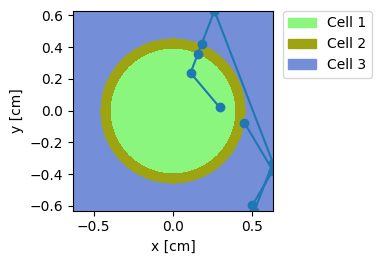

In [10]:
cell_colors = {}
for cell in model.geometry.get_all_cells().values():
    cell.name = f'Cell {cell.id}'
    cell_colors[cell] = np.random.choice(range(256), size=3)

ax = model.geometry.plot(colors=cell_colors, legend=True)
ax.plot(xs, ys, 'o-')
plt.show()

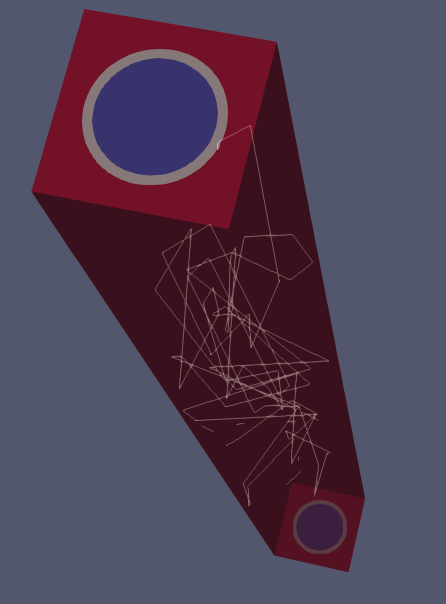

# Lost Particles

Lost particles are particles that enter an undefined region of space in the problem. Generally lost particles are caused by errors in geometry definitions or niche cases in computational geometry. When a lost particle occurs the following will appear in the OpenMC output:

```shell
 ===============>     FIXED SOURCE TRANSPORT SIMULATION     <===============

 Simulating batch 1
 WARNING: After particle 5 crossed surface 1 it could not be located in any cell
          and it did not leak.

```

After the number of lost particles exceeds the `settings.max_lost_particles` parameter, the simulation will halt with the following error message:

```shell
 WARNING: After particle 86 crossed surface 1 it could not be located in any
          cell and it did not leak.
 ERROR: Maximum number of lost particles has been reached.
```

For each lost particle produced by the simulation, a `particle_b_i.h5` file is produced containing the particle's state at the time it was lost, where `b` is the batch number and `i` is the particle ID.

OpenMC can be run in a mode where this single particle is run with additional output to assist in determining the cause of the problem.

For a particle restart file, `particle_1_100.h5`, this single particle can be executed in OpenMC using one of the following:

  - from a Python interpreter:
    - `model.run(particle_restart='particle_1_100.h5')`
    - `openmc.run(particle_restart='particle_1_100.h5')`
  - from the terminal
    - `$ openmc -r particle_1_100.h5`

In [11]:
# change the boundary condition of some surfaces to induce lost particles
for surf in model.geometry.get_all_surfaces().values():
    if isinstance(surf, openmc.XPlane):
        surf.boundary_type = 'transmission'

In [12]:
model.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

RuntimeError: Maximum number of lost particles has been reached. application called MPI_Abort(MPI_COMM_WORLD, -1) - process 0 [unset]: write_line error; fd=-1 buf=:cmd=abort exitcode=-1 : system msg for write_line failure : Bad file descriptor ERROR: Maximum number of lost particles has been reached. application called MPI_Abort(MPI_COMM_WORLD, -1) - process 0 [unset]: write_line error; fd=-1 buf=:cmd=abort exitcode=-1 : system msg for write_line failure : Bad file descriptor

In [13]:
import glob # Python built-in for getting collections of files
lost_particle_files = glob.glob('./particle_*.h5')
print(lost_particle_files)

['./particle_1_19.h5', './particle_1_47.h5', './particle_1_11.h5', './particle_1_20.h5', './particle_1_55.h5', './particle_1_13.h5', './particle_1_28.h5', './particle_1_2.h5', './particle_1_69.h5', './particle_1_61.h5', './particle_1_54.h5', './particle_1_12.h5', './particle_1_10.h5', './particle_1_62.h5', './particle_1_70.h5', './particle_1_93.h5', './particle_1_45.h5', './particle_1_37.h5', './particle_1_53.h5', './particle_1_1.h5', './particle_1_29.h5', './particle_1_56.h5', './particle_1_85.h5', './particle_1_46.h5']


In [14]:
model.run(restart_file=lost_particle_files[0])

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################